__Feature descriptions:__

- __PassengerId__ - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

- __HomePlanet__ - The planet the passenger departed from, typically their planet of permanent residence.

- __CryoSleep__ - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

- __Cabin__ - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

- __estination__ - The planet the passenger will be debarking to.

- __Age__ - The age of the passenger.

- __VIP__ - Whether the passenger has paid for special VIP service during the voyage.

- __RoomService__, __FoodCourt__, __ShoppingMall__, __Spa__, __VRDeck__ - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

- __Name__ - The first and last names of the passenger.

- __Transported__ - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# 0. Loading Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)

# 1. Data Loading 

## Loading train and test sets

In [2]:
# Save to df
train = pd.read_csv('spaceship-titanic/train.csv')
test = pd.read_csv('spaceship-titanic/test.csv')

# Shape and preview
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)

Train set shape: (8693, 14)
Test set shape: (4277, 13)


# 2. First look at data 

In [3]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
# features with float64 type
train.describe(include=["float64"]).T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [7]:
#features with object and bool types
train.describe(include=[object,bool]).T

,count,unique,top,freq
PassengerId,8693,8693,3470_01,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Juane Popelazquez,2
Transported,8693,2,True,4378


# 3. Checking for duplicates

In [8]:
# on train set
duplicate = train[train.duplicated()]

if duplicate.empty:
    print('No duplicate rows!')
else:
    print("Duplicate Rows :")
    duplicate

No duplicate rows!


# 4. Missing Values 

In [9]:
# Checking the total amount of empty values in the dataset
print(f' Missing Data: {train.isnull().sum().sum(): 5,.0f} Values')
print('')

 Missing Data:  2,324 Values



In [10]:
# Looking at NaN % within the train data
nan = pd.DataFrame(train.isna().sum(), columns = ['NaN_sum'])
nan['Percentage(%)'] = (nan['NaN_sum']/len(train))*100
# nan['Type'] = nan.index.dtype()
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])

types = []
for i in nan.index: 
    types.append(train[i].dtype)

nan['Type'] = types

nan

,NaN_sum,Percentage(%),Type
Age,179,2.059128,float64
RoomService,181,2.082135,float64
Destination,182,2.093639,object
FoodCourt,183,2.105142,float64
Spa,183,2.105142,float64
VRDeck,188,2.162660,float64
Cabin,199,2.289198,object
Name,200,2.300702,object
HomePlanet,201,2.312205,object
VIP,203,2.335212,object


# 5. Studying numerical features 

The numerical features are:

In [11]:
train.describe(include=["float64"]).T.index

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

# `Age`

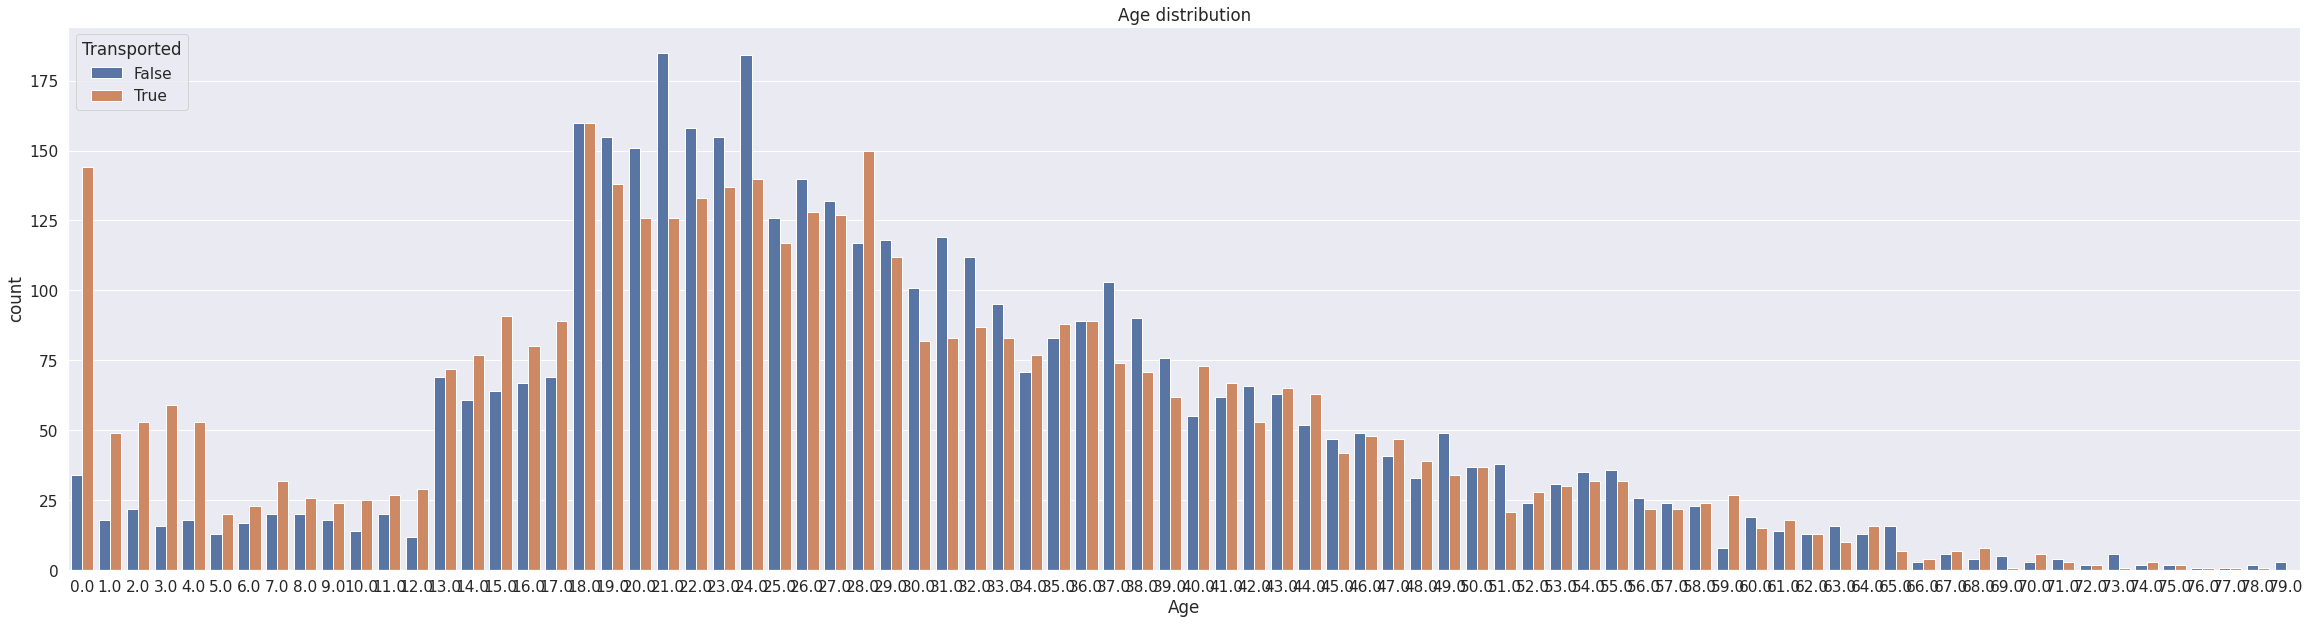

In [12]:
# Plot distribution of new features
plt.figure(figsize=(40, 10))

g=sns.countplot(data=train, x='Age', hue='Transported')
plt.title('Age distribution')
plt.show()

## Create `Age_group` feature

In [13]:
train['Age_group'] = np.nan

train.loc[train['Age']<= 18, 'Age_group'] = 'Age_0-18'
train.loc[(train['Age'] > 18) & (train['Age'] <= 36), 'Age_group'] = 'Age_19-36'
train.loc[(train['Age'] > 36) & (train['Age'] <= 50), 'Age_group'] = 'Age_37-50'
train.loc[train['Age'] > 50, 'Age_group'] = 'Age_50+'

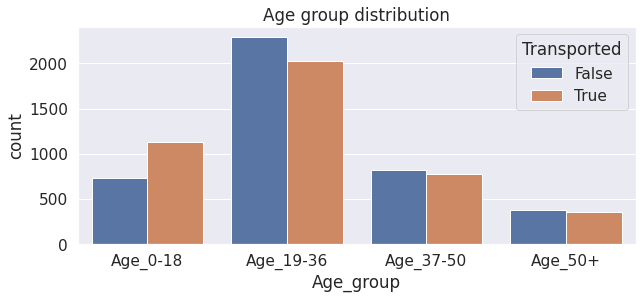

In [14]:
# Plot distribution of new features
plt.figure(figsize=(10,4))

g=sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-18','Age_19-36','Age_37-50','Age_50+'])
plt.title('Age group distribution')
plt.show()

## Create a feature with total expences of each passenger

In [15]:
expences = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

train['Total_expences'] = train['Expenditure'] = train[expences].sum(axis=1)

How many passengers did not spend anything?

In [16]:
train['Total_expences'][train['Total_expences'] == 0].count()

3653

Create a variable (0/1) describing if the current passenger spend anything or not!

In [17]:
train['No_spending'] = (train['Total_expences']==0).astype(int)

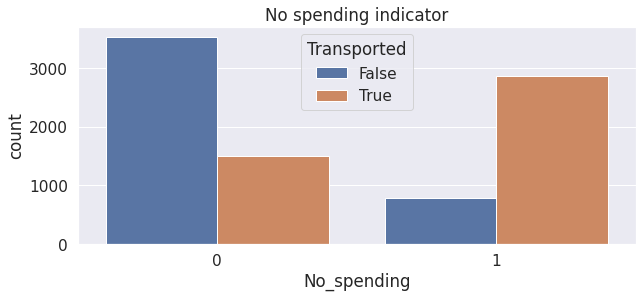

In [18]:
plt.figure(figsize=(10,4))

sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('No spending indicator')
plt.show()

# 6. Studying categorical data

## `PassengerId`

Extract passenger group and group size from PassengerId.

In [19]:
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
train['Group_size'] = train['PassengerId'].apply(lambda x: x.split('_')[1]).astype(int)

In [20]:
print(train['Group'].describe())

print('\nHow many unique Groups: ', train['Group'].nunique())

count    8693.000000
mean     4633.389624
std      2671.028856
min         1.000000
25%      2319.000000
50%      4630.000000
75%      6883.000000
max      9280.000000
Name: Group, dtype: float64

How many unique Groups:  6217


The `Group` feature doesn't seem to be usefull, so it will be droped.

In [21]:
train.drop(['Group'],axis=1,inplace=True)

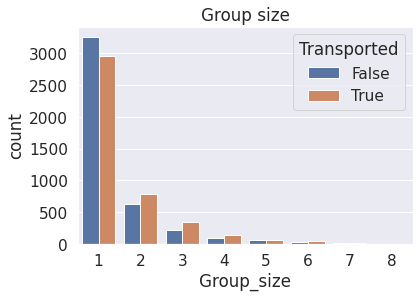

In [22]:
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
plt.show()

Most passengers are travelling alone. We will create a feature `Solo` indicating if the passenger is travelling alone.

In [23]:
train['Group_size'].value_counts()

1    6217
2    1412
3     571
4     231
5     128
6      75
7      46
8      13
Name: Group_size, dtype: int64

In [24]:
train['Solo'] = (train['Group_size'] == 1).astype(int)

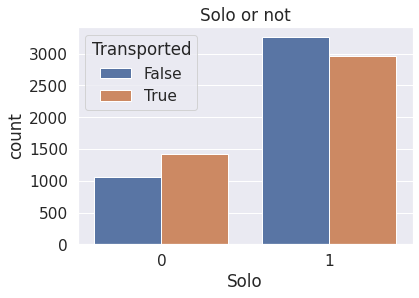

In [25]:
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Solo or not')
plt.show()

## `Cabin`

Fill _Nan_ in `Cabin` for now, in order to apply feature engineering techniques. We will fill _NaNs_ with outliers.

In [26]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'Age_group', 'Total_expences', 'Expenditure',
       'No_spending', 'Group_size', 'Solo'],
      dtype='object')

In [27]:
# Replace NaN's with outliers for now (so we can split feature)
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

In [28]:
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_num'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

In [29]:
# Put Nan's back in (we will fill these later)
train.loc[train['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train.loc[train['Cabin_num']==9999, 'Cabin_num']=np.nan
train.loc[train['Cabin_side']=='Z', 'Cabin_side']=np.nan

# Drop Cabin (we don't need it anymore)
train.drop('Cabin', axis=1, inplace=True)

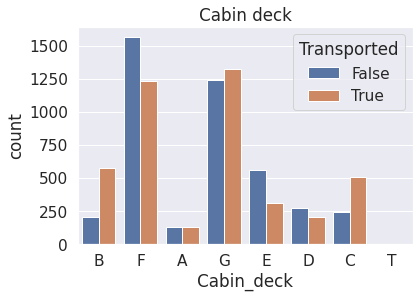

In [30]:
sns.countplot(data=train, x='Cabin_deck', hue='Transported')
plt.title('Cabin deck')
plt.show()

In [31]:
train['Cabin_deck'].value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Cabin_deck, dtype: int64

`Cabin_deck = 'T'` must be an outliers. It will be replaced with `nan`.

In [32]:
train.loc[train['Cabin_deck']=='T', 'Cabin_deck']=np.nan

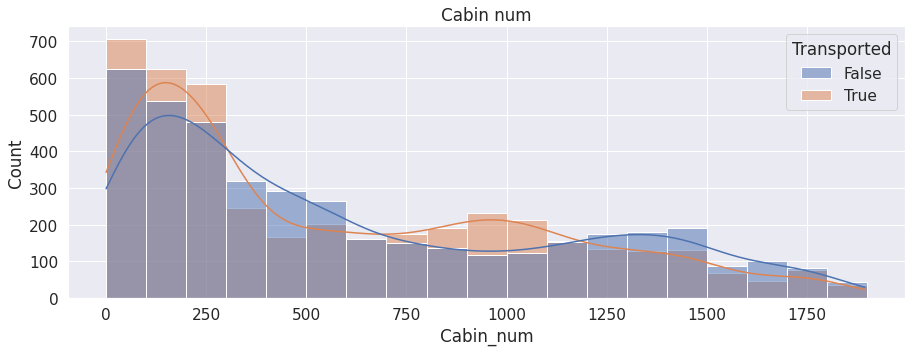

In [33]:
plt.figure(figsize=(15, 5))
sns.histplot(data=train, x='Cabin_num', hue='Transported', kde=True, binwidth=100)
plt.title('Cabin num')
plt.show()

Create `Cabin_num_group` feature

In [34]:
train['Cabin_num_group_1'] = (train['Cabin_num'] <= 300).astype(int)
train['Cabin_num_group_2'] = ((train['Cabin_num'] > 300) & (train['Cabin_num'] <= 700)).astype(int)
train['Cabin_num_group_3'] = ((train['Cabin_num'] > 700) & (train['Cabin_num'] <= 1200)).astype(int)
# train['Cabin_num_group_4'] = (train['Cabin_num'] > 1200).astype(int)  # Remove because of DUMMY TRAP

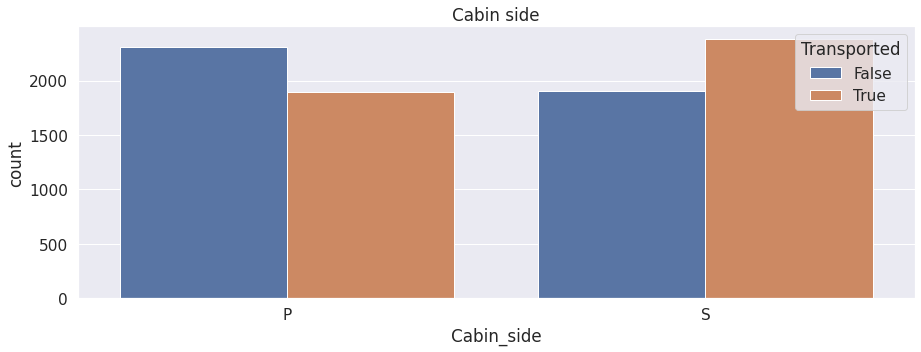

In [35]:
plt.figure(figsize=(15, 5))
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
plt.show()

In [36]:
def plot_pie_chart(dataframe,col):
    _, ax = plt.subplots(figsize=[18,6])
    dataframe.groupby([col]).size().plot(kind='pie',autopct='%.2f%%',ax=ax, title='',label=col)     

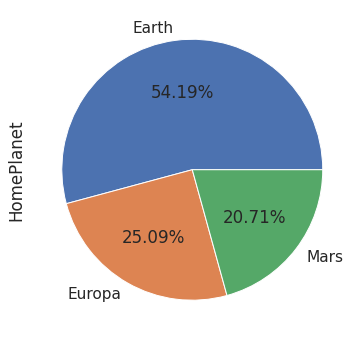

In [37]:
plot_pie_chart(train,col="HomePlanet")

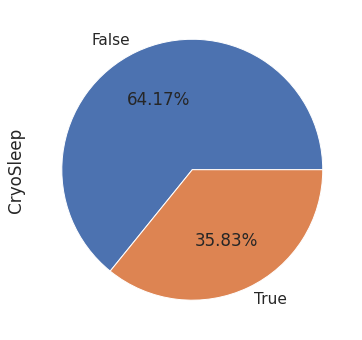

In [38]:
plot_pie_chart(train,col="CryoSleep")

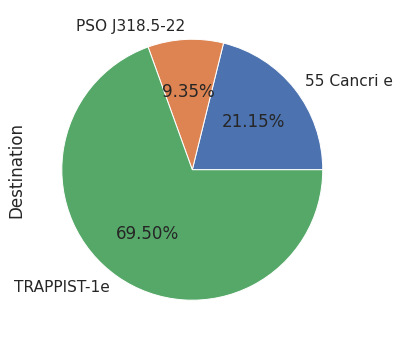

In [39]:
plot_pie_chart(train,col="Destination")

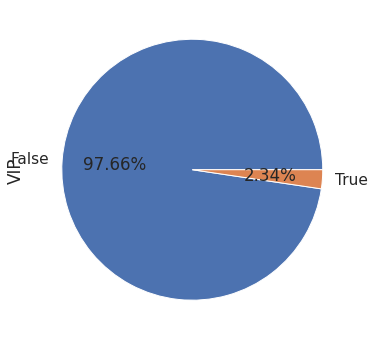

In [40]:
plot_pie_chart(train,col="VIP")

`VIP` doesn't seem to be useful feature, so it will be droped (maybe).

## Looking at target value

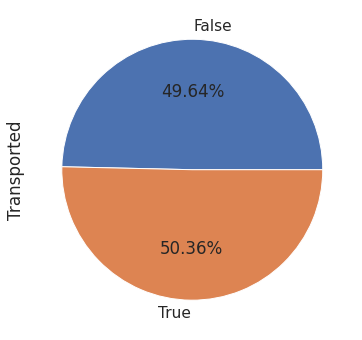

In [42]:
plot_pie_chart(train,col="Transported")

The __target__ variable is very balanced.

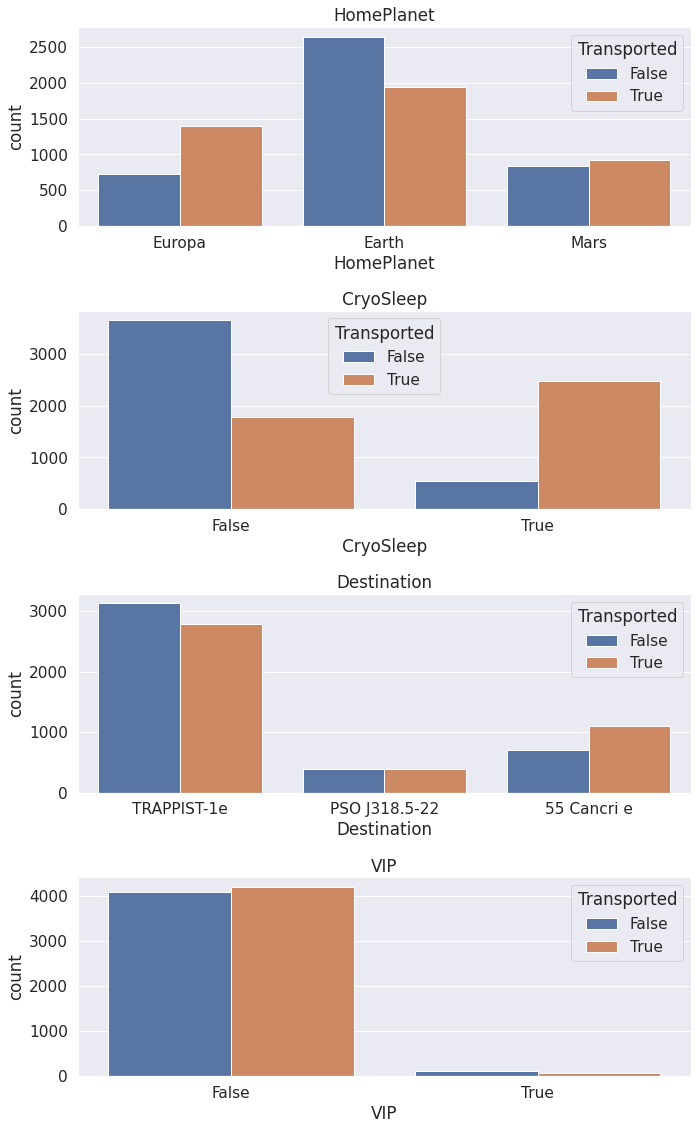

In [43]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

# 7. Imputing the missing data 

In [44]:
# Looking at NaN % within the train data
nan = pd.DataFrame(train.isna().sum(), columns = ['NaN_sum'])
nan['Percentage(%)'] = (nan['NaN_sum']/len(train))*100
# nan['Type'] = nan.index.dtype()
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])

types = []
for i in nan.index: 
    types.append(train[i].dtype)

nan['Type'] = types

nan

,NaN_sum,Percentage(%),Type
Age,179,2.059128,float64
Age_group,179,2.059128,object
RoomService,181,2.082135,float64
Destination,182,2.093639,object
FoodCourt,183,2.105142,float64
Spa,183,2.105142,float64
VRDeck,188,2.162660,float64
Cabin_num,199,2.289198,float64
Cabin_side,199,2.289198,object
Name,200,2.300702,object


## Filling missing `CryoSleep`

If someone is in `CryoSleep`, they wouldn't spend anything...

In [45]:
train['CryoSleep'].fillna(train['No_spending'], inplace=True)

In [46]:
print('CryoSleep missing values: ', train['CryoSleep'].isna().sum())

CryoSleep missing values:  0


## Filling missing `HomePlanet`

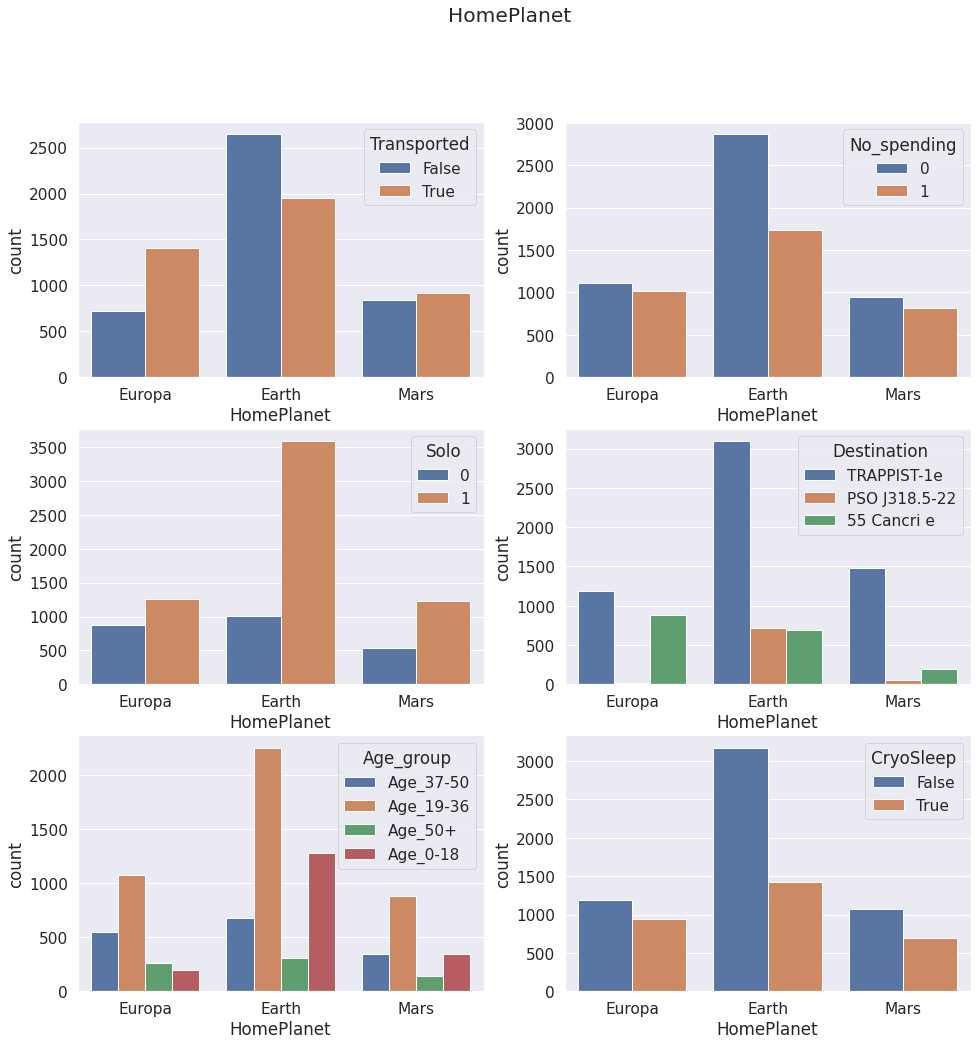

In [47]:
fig, axes = plt.subplots(3, 2, figsize=(16,16))
fig.suptitle('HomePlanet')
sns.countplot(ax=axes[0][0], data=train, x='HomePlanet', hue='Transported')
sns.countplot(ax=axes[0][1], data=train, x='HomePlanet', hue='No_spending')
sns.countplot(ax=axes[1][0], data=train, x='HomePlanet', hue='Solo')
sns.countplot(ax=axes[1][1], data=train, x='HomePlanet', hue='Destination')
sns.countplot(ax=axes[2][0], data=train, x='HomePlanet', hue='Age_group')
sns.countplot(ax=axes[2][1], data=train, x='HomePlanet', hue='CryoSleep')
plt.show()

In [48]:
for i in train[train['HomePlanet'].isnull()].index:
    if((train.iloc[i]['Solo']==1) & (train.iloc[i]['Transported']==0) & (train.iloc[i]['CryoSleep']==0) & (train.iloc[i]['No_spending']==0)):
        train.loc[i, 'HomePlanet'] = 'Earth'

In [49]:
for i in train[train['HomePlanet'].isnull()].index:
    if((train.iloc[i]['Destination']=='TRAPPIST-1e')):
        train.loc[i, 'HomePlanet'] = 'Mars'

In [50]:
train['HomePlanet'] = train['HomePlanet'].fillna('Europa')

In [51]:
print('HomePlanet missing values: ', train['HomePlanet'].isna().sum())

HomePlanet missing values:  0


## Filling missing `Age`

In [52]:
train['Age'] = train['Age'].fillna(train.groupby(['HomePlanet', 'Solo', 'No_spending'])['Age'].transform('median'))

In [53]:
print('Age missing values: ', train['Age'].isna().sum())

Age missing values:  0


### Fill alse `Age_group`

In [54]:
train.loc[train['Age']<= 18, 'Age_group'] = 'Age_0-18'
train.loc[(train['Age'] > 18) & (train['Age'] <= 36), 'Age_group'] = 'Age_19-36'
train.loc[(train['Age'] > 36) & (train['Age'] <= 50), 'Age_group'] = 'Age_37-50'
train.loc[train['Age'] > 50, 'Age_group'] = 'Age_50+'

In [55]:
print('Age_group missing values: ', train['Age_group'].isna().sum())

Age_group missing values:  0


## Filling missing `Destination`

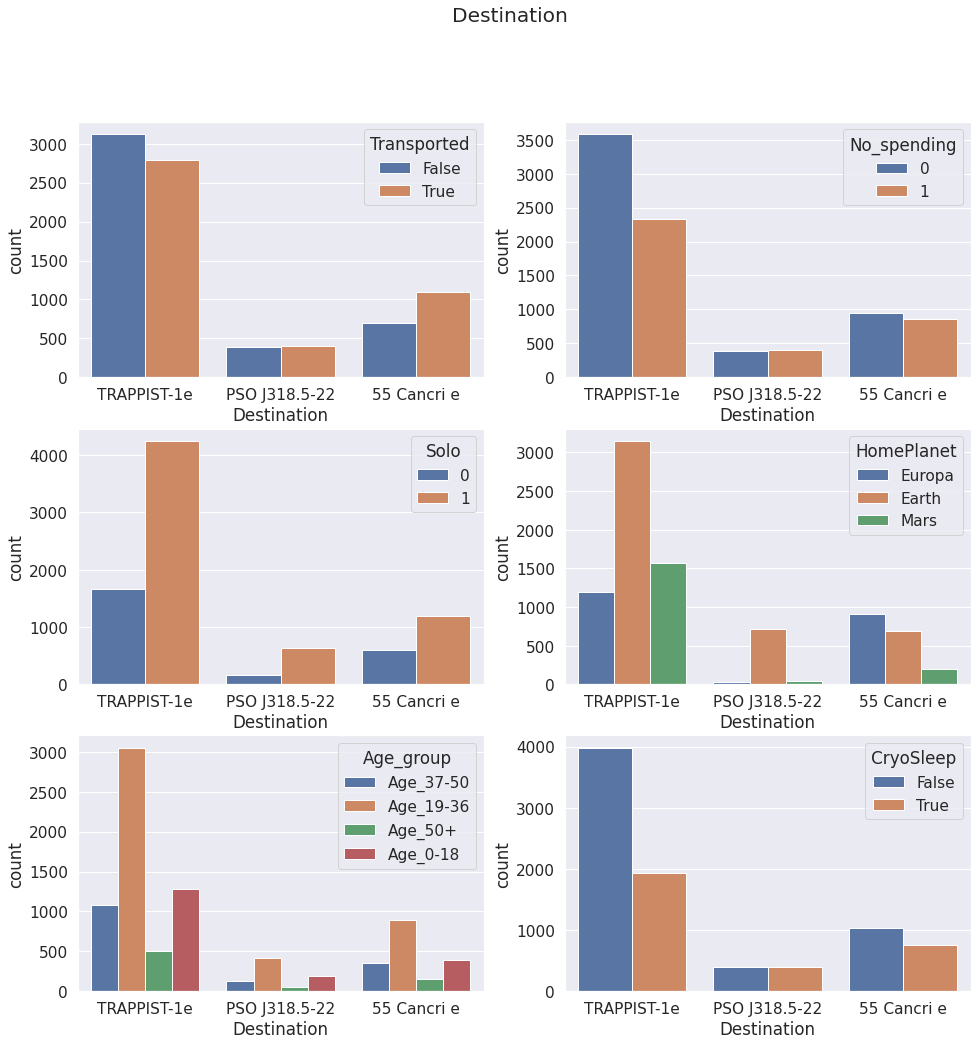

In [56]:
fig, axes = plt.subplots(3, 2, figsize=(16,16))
fig.suptitle('Destination')
sns.countplot(ax=axes[0][0], data=train, x='Destination', hue='Transported')
sns.countplot(ax=axes[0][1], data=train, x='Destination', hue='No_spending')
sns.countplot(ax=axes[1][0], data=train, x='Destination', hue='Solo')
sns.countplot(ax=axes[1][1], data=train, x='Destination', hue='HomePlanet')
sns.countplot(ax=axes[2][0], data=train, x='Destination', hue='Age_group')
sns.countplot(ax=axes[2][1], data=train, x='Destination', hue='CryoSleep')
plt.show()

In [57]:
for i in train[train['Destination'].isnull()].index:
    if((train.iloc[i]['HomePlanet']=='Europa')): 
        train.loc[i, 'Destination'] = '55 Cancri e'

In [58]:
train['Destination'] = train['Destination'].fillna(train['Destination'].mode()[0])

In [59]:
print('Destination missing values: ', train['Destination'].isna().sum())

Destination missing values:  0


## Filling `Cabin_side`

In [60]:
train['Cabin_side'].value_counts()

S    4288
P    4206
Name: Cabin_side, dtype: int64

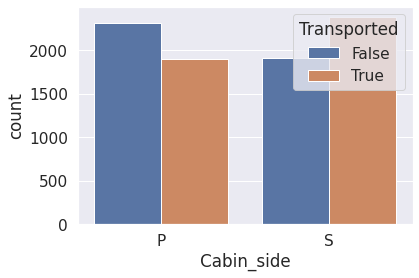

In [61]:
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.show()

If the person is Transported, we will fill the nan Cabin_side with  S.

In [62]:
for i in train[train['Cabin_side'].isnull()].index:
    if(train.iloc[i]['Transported']==1): 
        train.loc[i, 'Cabin_side'] = 'S'
    else: 
        train.loc[i, 'Cabin_side'] = 'P'

In [63]:
print('Cabin_side missing values: ', train['Cabin_side'].isna().sum())

Cabin_side missing values:  0


## Filling `Cabind_deck` 

In [64]:
train['Cabin_deck'].value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
Name: Cabin_deck, dtype: int64

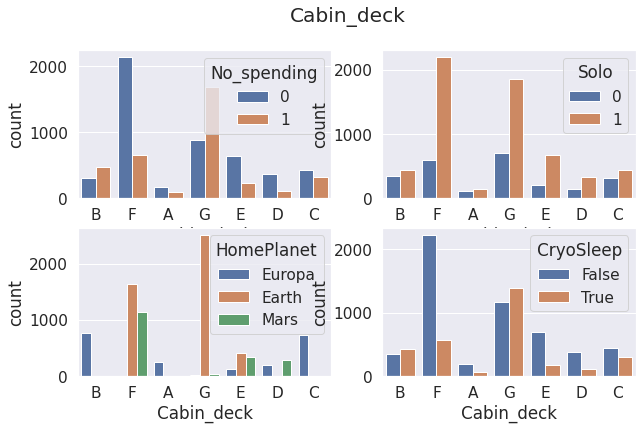

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(10,6))
fig.suptitle('Cabin_deck')
sns.countplot(ax=axes[0][0], data=train, x='Cabin_deck', hue='No_spending')
sns.countplot(ax=axes[0][1], data=train, x='Cabin_deck', hue='Solo')
sns.countplot(ax=axes[1][0], data=train, x='Cabin_deck', hue='HomePlanet')
sns.countplot(ax=axes[1][1], data=train, x='Cabin_deck', hue='CryoSleep')
plt.show()

In [66]:
for i in train[train['Cabin_deck'].isnull()].index:
    if((train.iloc[i]['No_spending']==1) & (train.iloc[i]['HomePlanet']=='Earth')): 
        train.loc[i, 'Cabin_deck'] = 'G'
    else: 
        train.loc[i, 'Cabin_deck'] = 'F'

In [67]:
print('Cabin_deck missing values: ', train['Cabin_deck'].isna().sum())

Cabin_deck missing values:  0


# 8. Drop unusefull columns

In [68]:
train.drop(['Name','VIP','Cabin_num'],axis=1,inplace=True)

# 9. Filling remaining missing values on numerical features

In [69]:
train.loc[train['No_spending']==1, 'RoomService'] = 0
train.loc[train['No_spending']==1, 'FoodCourt'] = 0
train.loc[train['No_spending']==1, 'Spa'] = 0
train.loc[train['No_spending']==1, 'ShoppingMall'] = 0

In [70]:
from sklearn.impute import SimpleImputer

# filling the null values with median 

imputer_cols = ["FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy="median" )
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])

# 10. Set index `PassengerId` 

In [71]:
train = train.set_index('PassengerId')

In [72]:
train.head(2)

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,Total_expences,Expenditure,No_spending,Group_size,Solo,Cabin_deck,Cabin_side,Cabin_num_group_1,Cabin_num_group_2,Cabin_num_group_3
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,False,...,0.0,0.0,1,1,1,B,P,1,0,0
0002_01,Earth,False,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,True,...,736.0,736.0,0,1,1,F,S,1,0,0


# 11. Encode boolean variable (True/False to 1/0)

In [73]:
# label encoding 
from sklearn.preprocessing import LabelEncoder

label_cols = ["HomePlanet", "CryoSleep", "Destination", "Age_group", "Cabin_deck", "Cabin_side", "Group_size"]
def label_encoder(df, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
    return df

train = label_encoder(train, label_cols)
train.shape

(8693, 21)

In [74]:
for col in label_cols:
    dummies = pd.get_dummies(train[col], prefix=col, drop_first=True)
    train = pd.concat([train, dummies], axis=1)
    train.drop([col], axis=1, inplace=True)

print(train.shape)

(8693, 38)


In [75]:
train['Transported'] = train['Transported'].astype(int)

In [76]:
train.head(3)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Total_expences,Expenditure,No_spending,...,Cabin_deck_5,Cabin_deck_6,Cabin_side_1,Group_size_1,Group_size_2,Group_size_3,Group_size_4,Group_size_5,Group_size_6,Group_size_7
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,1,736.0,736.0,0,...,1,0,1,0,0,0,0,0,0,0
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,0,10383.0,10383.0,0,...,0,0,1,0,0,0,0,0,0,0


# 12. SAVE FINAL .CSV 

In [77]:
train.to_csv('dataset.csv', index=True)

In [78]:
dataset = pd.read_csv('dataset.csv')

In [79]:
dataset

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Total_expences,Expenditure,...,Cabin_deck_5,Cabin_deck_6,Cabin_side_1,Group_size_1,Group_size_2,Group_size_3,Group_size_4,Group_size_5,Group_size_6,Group_size_7
0,0001_01,39.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0002_01,24.0,109.0,9.0,25.0,549.0,44.0,1,736.0,736.0,...,1,0,1,0,0,0,0,0,0,0
2,0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,0,10383.0,10383.0,...,0,0,1,0,0,0,0,0,0,0
3,0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,0,5176.0,5176.0,...,0,0,1,1,0,0,0,0,0,0
4,0004_01,16.0,303.0,70.0,151.0,565.0,2.0,1,1091.0,1091.0,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,41.0,0.0,6819.0,0.0,1643.0,74.0,0,8536.0,8536.0,...,0,0,0,0,0,0,0,0,0,0
8689,9278_01,18.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0,1,1,0,0,0,0,0,0,0
8690,9279_01,26.0,0.0,0.0,1872.0,1.0,0.0,1,1873.0,1873.0,...,0,1,1,0,0,0,0,0,0,0
8691,9280_01,32.0,0.0,1049.0,0.0,353.0,3235.0,0,4637.0,4637.0,...,0,0,1,0,0,0,0,0,0,0


# Run a fast Logistic Regression

In [80]:
X = train.drop(['Transported'],axis=1)
y = train['Transported']

In [81]:
from sklearn.model_selection import train_test_split

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,
                                                      train_size=0.8,test_size=0.2,random_state=0)

## Normalize data

In [82]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [83]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [84]:
y_pred = model.predict(X_valid)

In [85]:
# Accuracy
from sklearn.metrics import accuracy_score

accuracy_score(y_valid, y_pred)

0.7906843013225991

In [86]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.7906843013225991